# **EDF R&D Digital Innovation – NLP Test**

---

Welcome to the NLP technical test. The purpose of this test is to evaluate your coding skills and your understanding of some fundamental concepts in NLP. Please note that we will not judge you based on evaluation metrics or the final performance of your algorithm. Instead, we want to understand how you approach this challenge, so we will pay attention to how you frame the problem, what techniques you use and any clever tricks you apply, the frameworks you choose, how you approach modelling and your overall reasoning and use of critical thinking. Therefore, documenting your reasoning is highly encouraged.

Regarding computational resources, the google colab free tier GPU should be enough for a working solution to this challenge; you are not expected to pay out of your pocket to rent GPU time or consume your own LLM credits, and you will not be reimbursed. The dataset chosen here is challenging and we don't expect a perfect solution within the timeframe and resources allowed; as mentioned before, we will not judge you on the metrics you obtain but on your approach to the problem. With this in mind, feel free to leverage any resources you may want to use, as long as the final version of this notebook is self-contained.

Usage of AI is allowed but we expect you will be transparent about AI assistance, and you will be able to justify any given line of code on request.

Finally, please ensure that the outputs of all your cells are visible when you upload your solution.
If you have any questions or need any support with this test, please email: gustavo.medinavazquez@edfenergy.com

Good luck!

---


*Candidate Name: Luc Rolland

# Instructions

The objective is to build a text classifier to identify toxic comments. We have segmented this notebook into different sections but this structure is just a suggestion, please feel free to adapt the sections to your own working style. The only fixed requirements are that you should develop a model and provide an evaluation of your solution. In particular, we will look for:
* Data exploration and cleaning (if needed)
* Data pipelines and pre/post-processing methods (if any)
* How to evaluate the performance of the model
* How you build and optimise an NLP model
* Visualisations or analysis of the results and the data
* Code organisation and readability

Documenting your notebook is highly encouraged.

We will use the mteb toxic comments dataset: https://huggingface.co/datasets/mteb/toxic_conversations_50k
The cells in this section download the training and testing splits of the dataset in the form of a HuggingFace dataset object.

In [1]:
!pip install datasets

  Using cached datasets-4.0.0-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached numpy-2.3.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached pandas-2.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached PyYAML-6.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached typing_extensions-4.14.1-py3-none

In [2]:
import datasets

dataset_train = datasets.load_dataset('mteb/toxic_conversations_50k', split='train')
dataset_val = datasets.load_dataset('mteb/toxic_conversations_50k', split='test')

/Users/svl_rolla1l/Documents/pentago/SuperPentago/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 50000/50000 [00:00<00:00, 1647823.49 examples/s]


The dataset object contains 3 keys:
* text: the raw text
* label: a numeric label (1 for toxic, 0 for non-toxic)
* label_text: the label as a string

In [3]:
print(dataset_train)

Dataset({
    features: ['text', 'label', 'label_text'],
    num_rows: 50000
})


The dataset is indexable and you can extract the raw text into a list or write it to a temporary file if you prefer.

In [ ]:
# # to extract the text into a list
# dataset_train[:3]['text']

# # to write into a file
# with open('temp.txt', 'w') as f:
#   for text in dataset_train['text']:
#     f.write(text+'\n')

Now that you have access to the raw data, feel free to use whatever approach and libraries you want.

Tip: if you're using google colab, you can mount your drive to this notebook so you can save and load files on google drive:

In [ ]:
# # Mount your drive to this Colab notebook

# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

If you need to install libraries that are not included in this environment, you can use
`!pip install [package-name]`.

In [12]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             average_precision_score, precision_recall_curve, roc_curve, f1_score)
from sklearn.utils.class_weight import compute_class_weight

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

import nltk
nltk.download('punkt', quiet=True)


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")


Device: cpu


# Data preprocessing

In [13]:
# Load the MTEB toxic conversations dataset (train/test) and wrap both splits 
# into a DatasetDict; display it for a quick sanity check.

dataset_train = load_dataset('mteb/toxic_conversations_50k', split='train')
dataset_val   = load_dataset('mteb/toxic_conversations_50k', split='test')

ds = DatasetDict({
    "train": dataset_train,
    "validation": dataset_val
})
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 50000
    })
})

In [ ]:
# Compute simple length features (word counts) for train/validation and show descriptive stats 
# for the train split.

df_train = ds["train"].to_pandas()
df_val   = ds["validation"].to_pandas()
df_train.head(3)


,text,label,label_text
0,theres not enough going on around here for air...,0,not toxic
1,How about ZERO,0,not toxic
2,Her name is still floating? Might I suggest f...,0,not toxic


In [19]:
df_train['label'].map({0: 'not toxic', 1: 'toxic'}).value_counts(normalize=True).mul(100).round(2)

label
not toxic    92.07
toxic         7.93
Name: proportion, dtype: float64

In [22]:
df_train['len'] = df_train['text'].str.split().apply(len)
df_val['len']   = df_val['text'].str.split().apply(len)
df_train['len'].describe()

count    50000.000000
mean        51.565620
std         46.325654
min          1.000000
25%         16.000000
50%         35.000000
75%         72.000000
max        210.000000
Name: len, dtype: float64

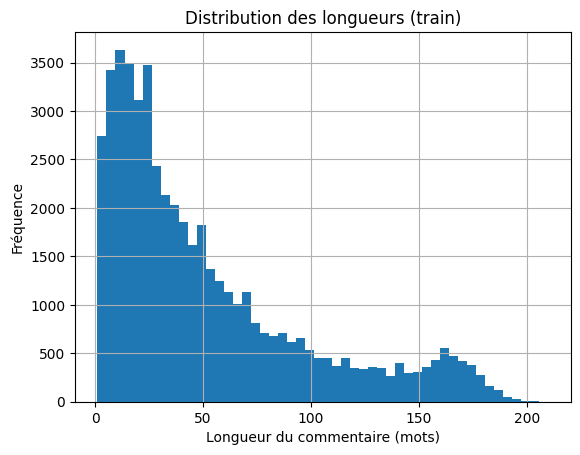

In [ ]:
# Plot the distribution of comment lengths (train split) to understand text size variability.

plt.figure()
df_train['len'].hist(bins=50)
plt.xlabel("Comment length (words)")
plt.ylabel("Frequency")
plt.title("Length distribution (train)")
plt.show()

# Modelling

In [27]:
# Minimal text cleaning for the classic baseline (lowercase, remove URLs/extra spaces), 
# then build NumPy arrays for sklearn; print one cleaned example.

import re

def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_train['text_clean'] = df_train['text'].apply(basic_clean)
df_val['text_clean']   = df_val['text'].apply(basic_clean)

X_train_clf = df_train['text_clean'].values
y_train = df_train['label'].values
X_val_clf   = df_val['text_clean'].values
y_val   = df_val['label'].values

print("Eexample:", X_train_clf[0][:300])


Eexample: theres not enough going on around here for air service none want to waste there time on this town


### Model 1 — Baseline TF-IDF + Logistic Regression
- Represent comments with **TF-IDF** over **1–2 word n-grams**, emphasizing terms frequent in a document but rare overall.
- Train a **linear classifier** (logistic regression) to separate toxic vs. non-toxic with a single decision boundary.
- Handle **class imbalance** via `class_weight='balanced'` and **oversampling** (RandomOverSampler).
- **Fast**, **lightweight**, and **interpretable**: model coefficients reveal n-grams most associated with toxicity/non-toxicity.
- Limitations: weaker at modeling **context**, sarcasm, and paraphrases; dependent on seen vocabulary.
- Strong **baseline** to benchmark before moving to neural Transformers.

In [28]:
# Train a classic baseline: TF-IDF (1–2 grams) + class-balanced Logistic Regression with oversampling;
# then evaluate on the validation set (classification report, ROC-AUC, PR-AUC, confusion matrix).

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.99,
    strip_accents='unicode',
    sublinear_tf=True
)

classes = np.array([0,1])
class_weights = compute_class_weight(
    class_weight='balanced', classes=classes, y=y_train
)
cw = {cls: w for cls, w in zip(classes, class_weights)}
print("Class weights:", cw)

logreg = LogisticRegression(
    max_iter=200,
    class_weight=cw,
    solver='liblinear',
    C=1.0
)

pipeline = ImbPipeline(steps=[
    ('vectorizer', vectorizer),
    ('ros', RandomOverSampler()),
    ('clf', logreg),
])

pipeline.fit(X_train_clf, y_train)
proba_val = pipeline.predict_proba(X_val_clf)[:,1]
pred_val_05 = (proba_val >= 0.5).astype(int)

print(classification_report(y_val, pred_val_05, digits=3))
print("ROC‑AUC :", roc_auc_score(y_val, proba_val))
print("PR‑AUC  :", average_precision_score(y_val, proba_val))

cm = confusion_matrix(y_val, pred_val_05)
print("\nconfusion matrice:\n", cm)


Class weights: {np.int64(0): np.float64(0.5430650591940914), np.int64(1): np.float64(6.305170239596469)}
              precision    recall  f1-score   support

           0      0.985     0.720     0.832     46046
           1      0.211     0.874     0.340      3954

    accuracy                          0.732     50000
   macro avg      0.598     0.797     0.586     50000
weighted avg      0.924     0.732     0.793     50000

ROC‑AUC : 0.8914900663102815
PR‑AUC  : 0.5567955418763993

Matrice de confusion (seuil 0.5):
 [[33131 12915]
 [  497  3457]]


In [29]:
# Interpretability of the baseline: list the top n-grams most associated with TOXIC vs NON-TOXIC
# using the logistic regression coefficients on the TF-IDF features.

clf = pipeline.named_steps['clf']
tfidf = pipeline.named_steps['vectorizer']

feature_names = np.array(tfidf.get_feature_names_out())
coefs = clf.coef_[0]

top_pos_idx = np.argsort(coefs)[-20:][::-1]
top_neg_idx = np.argsort(coefs)[:20]

print("\nTop 20 n-grams associated with the TOXIC class:")
for i in top_pos_idx:
    print(f"{feature_names[i]}\t{coefs[i]:.3f}")

print("\nTop 20 n-grams associated with the NON-TOXIC class:")
for i in top_neg_idx:
    print(f"{feature_names[i]}\t{coefs[i]:.3f}")


Top 20 n‑grams associés à la classe TOXIQUE:
stupid 	 29.506
idiot 	 15.928
ignorant 	 15.587
pathetic 	 15.084
idiots 	 15.061
stupidity 	 14.939
ridiculous 	 14.029
dumb 	 13.851
crap 	 13.566
damn 	 11.907
fool 	 11.500
fools 	 11.228
ass 	 11.079
silly 	 10.857
garbage 	 10.236
black 	 10.004
white 	 9.776
loser 	 9.521
idiotic 	 9.350
clown 	 9.348

Top 20 n‑grams associés à la classe NON‑TOXIQUE:
different 	 -3.768
in 	 -3.253
great 	 -3.236
interesting 	 -3.235
doesn 	 -3.032
second 	 -2.996
may 	 -2.982
it is 	 -2.941
much 	 -2.829
many 	 -2.796
amazing 	 -2.791
in our 	 -2.769
point 	 -2.733
thank you 	 -2.727
are not 	 -2.674
business 	 -2.628
system 	 -2.540
tax 	 -2.515
information 	 -2.482
living 	 -2.460


### Model 2 — DistilBERT (Transformer) Fine-tuned
- Start from **DistilBERT**, a compact, pre-trained Transformer; add a **classification head** and **fine-tune** on toxicity labels.
- **Tokenization** yields `input_ids` and `attention_mask`; **self-attention** captures long-range context and nuanced meaning.
- Train with Hugging Face **Trainer**/**TrainingArguments**; evaluate using **ROC-AUC**, **PR-AUC**, and **F1** with an optimized threshold.
- Typically achieves **higher quality**, especially **PR-AUC** on rare positives, and is more robust to rephrasing.
- Trade-offs: **heavier** compute (GPU recommended) and **less interpretable** than linear baselines.
- Preferred when you need **best performance** and can afford the extra training/inference cost.

In [46]:
# Fine-tune DistilBERT end-to-end: Pandas -> HF Datasets,
# build TrainingArguments, train and evaluate.

import os, random, numpy as np, torch, inspect
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

os.environ["TOKENIZERS_PARALLELISM"] = "false"

MODEL_NAME = "distilbert-base-uncased"
MAX_LEN = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

try:
    df_train, df_val 
except NameError:
    ds_train = load_dataset('mteb/toxic_conversations_50k', split='train')
    ds_val   = load_dataset('mteb/toxic_conversations_50k', split='test')
    df_train = ds_train.to_pandas()
    df_val   = ds_val.to_pandas()

df_train2 = (df_train[['text','label']].dropna().reset_index(drop=True).rename(columns={'label':'labels'}))
df_val2   = (df_val[['text','label']].dropna().reset_index(drop=True).rename(columns={'label':'labels'}))
df_train2['labels'] = df_train2['labels'].astype('int64')
df_val2['labels']   = df_val2['labels'].astype('int64')

raw_ds = DatasetDict({
    "train": Dataset.from_pandas(df_train2),
    "validation": Dataset.from_pandas(df_val2),
})

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    enc = tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
    enc["labels"] = batch["labels"]
    return enc

tokenized_ds = raw_ds.map(tok, batched=True, remove_columns=raw_ds["train"].column_names)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.softmax(torch.tensor(logits), dim=1)[:, 1].numpy()
    preds = (probs >= 0.5).astype(int)
    return {
        "roc_auc": float(roc_auc_score(labels, probs)),
        "pr_auc": float(average_precision_score(labels, probs)),
        "f1": float(f1_score(labels, preds)),
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def build_training_args() -> TrainingArguments:
    STRAT = "epoch"
    sig = inspect.signature(TrainingArguments.__init__)
    ta = dict(
        output_dir="./outputs",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=2,
        weight_decay=0.01,
        logging_steps=50,
    )
    if "evaluation_strategy" in sig.parameters:
        ta["evaluation_strategy"] = STRAT
    if "eval_strategy" in sig.parameters:
        ta["eval_strategy"] = STRAT
    if "save_strategy" in sig.parameters:
        ta["save_strategy"] = STRAT
    if "do_eval" in sig.parameters:
        ta["do_eval"] = True
    if "report_to" in sig.parameters:
        ta["report_to"] = "none"
    if "load_best_model_at_end" in sig.parameters:
        ta["load_best_model_at_end"] = True
    if "metric_for_best_model" in sig.parameters:
        ta["metric_for_best_model"] = "pr_auc"
    if "greater_is_better" in sig.parameters:
        ta["greater_is_better"] = True
    return TrainingArguments(**ta)

training_args = build_training_args()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
trainer.train()
trainer.evaluate()

Map: 100%|██████████| 50000/50000 [00:06<00:00, 7538.69 examples/s]
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/h5/01chx0t50qzc510cx0_sb39m0000gn/T/ipykernel_25401/3005768012.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/svl_rolla1l/Documents/pentago/SuperPentago/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Roc Auc,Pr Auc,F1
1,0.154600,0.161990,0.945433,0.707815,0.610492
2,0.047500,0.169249,0.947924,0.716273,0.641754


/Users/svl_rolla1l/Documents/pentago/SuperPentago/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/svl_rolla1l/Documents/pentago/SuperPentago/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.16924934089183807,
 'eval_roc_auc': 0.947924494190246,
 'eval_pr_auc': 0.7162733201674013,
 'eval_f1': 0.641753998896856,
 'eval_runtime': 320.3749,
 'eval_samples_per_second': 156.067,
 'eval_steps_per_second': 4.879,
 'epoch': 2.0}

/Users/svl_rolla1l/Documents/pentago/SuperPentago/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Optimal threshold (Transformer, max F1): 0.272 — F1=0.652
ROC-AUC: 0.947924494190246
PR-AUC: 0.7162733201674013


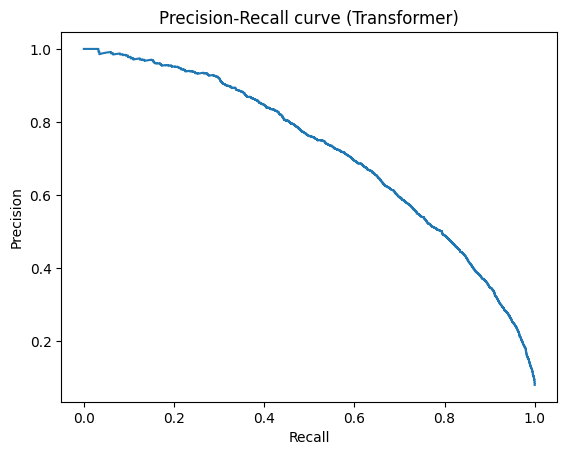

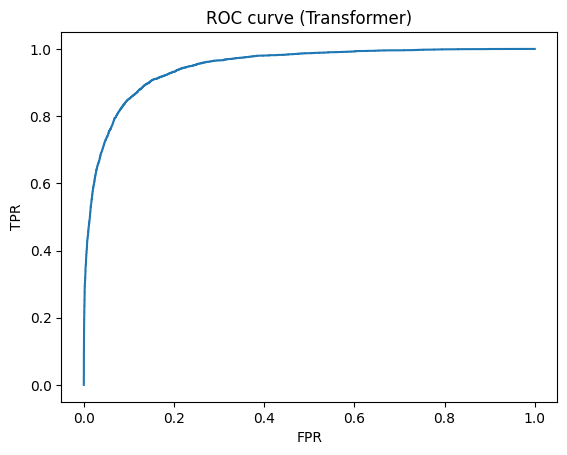


== Report (Transformer, optimal threshold) ==
              precision    recall  f1-score   support

           0      0.969     0.972     0.971     46046
           1      0.661     0.642     0.652      3954

    accuracy                          0.946     50000
   macro avg      0.815     0.807     0.811     50000
weighted avg      0.945     0.946     0.945     50000

Confusion matrix:
 [[44746  1300]
 [ 1415  2539]]


In [ ]:
# Inference via Trainer (no manual tensors/MPS quirks)
pred = trainer.predict(tokenized_ds["validation"])

import torch
logits = torch.tensor(pred.predictions)              
probs  = torch.softmax(logits, dim=1)[:, 1].numpy()
y_true = pred.label_ids

from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score, classification_report, confusion_matrix, roc_curve

precision, recall, thr = precision_recall_curve(y_true, probs)
f1s = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-9)
best_idx = f1s.argmax()
best_thr = thr[best_idx]

print(f"Optimal threshold (Transformer, max F1): {best_thr:.3f} — F1={f1s[best_idx]:.3f}")
print("ROC-AUC:", roc_auc_score(y_true, probs))
print("PR-AUC:", average_precision_score(y_true, probs))

plt.figure(); plt.plot(recall, precision); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall curve (Transformer)"); plt.show()

fpr, tpr, _ = roc_curve(y_true, probs)
plt.figure(); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve (Transformer)"); plt.show()

preds = (probs >= best_thr).astype(int)
print("\n== Report (Transformer, optimal threshold) ==")
print(classification_report(y_true, preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_true, preds))

# Conclusions

Feel free to use this space to provide any additional explanations or thoughts about the test. This can include comments, critical reflections about the challenge or data, how the solution could be improved, and any other ideas for further work or relevant topics that were not included here.

In [53]:
# Error analysis: list the top-k false positives/negatives (by model confidence) 
# to inspect typical mistakes.
import numpy as np
def top_errors(y_true, y_prob, k=10):
    preds = (y_prob >= 0.5).astype(int)
    fp_idx = np.where((preds==1) & (y_true==0))[0]
    fn_idx = np.where((preds==0) & (y_true==1))[0]
    fp_sorted = fp_idx[np.argsort(-y_prob[fp_idx])][:k]
    fn_sorted = fn_idx[np.argsort(y_prob[fn_idx])][:k]
    return fp_sorted, fn_sorted

fp_ids, fn_ids = top_errors(y_true, probs, k=10)

print("\n--- False positives (predicted toxic, actually non-toxic) ---")
for i in fp_ids:
    print(f"[p={probs[i]:.3f}] {df_val['text'].iloc[i][:300]}")

print("\n--- False negatives (predicted non-toxic, actually toxic) ---")
for i in fn_ids:
    print(f"[p={probs[i]:.3f}] {df_val['text'].iloc[i][:300]}")


--- False positives (predicted toxic, actually non-toxic) ---
[p=0.995] how do you know
I lived under marxist governments you moron
[p=0.995] ... what a spoiled BRAT MORON we have as a President!!
[p=0.995] "How about you and the govt. stay out of my healthcare choices (and wallet)?"

Are you on Medicare?

If not, will you accept Medicare when you turn 65?

If the answer to either in "Yes", you are the rankest of hypocrites.
[p=0.994] Dumb is a good posting name for you IMO
[p=0.994] and as usual a bs lib troll spewing the usual crap, no lib loser, a peice of toast would be better for ontario over liberals, hence brown is a great alternative
[p=0.994] Maybe Trump doesn't know about the time Jesus flipped out at the money changers at the Temple.  

"This Jesus.  Some kind of socialist?  Christianity -- a hoax by the Chinese to kill out economy.  Pathetic."
[p=0.994] Putin played Trump, his chief suckee, like a balalaika and the mentally impoverished sociopath fell for the Russian lulla

### Conclusion

After having considered the gap between the predictions of my model and the true results, I think that my model is better than those who made the dataset in considering what is toxic or not. I could therefore propose to them to use my model for the next evaluation.